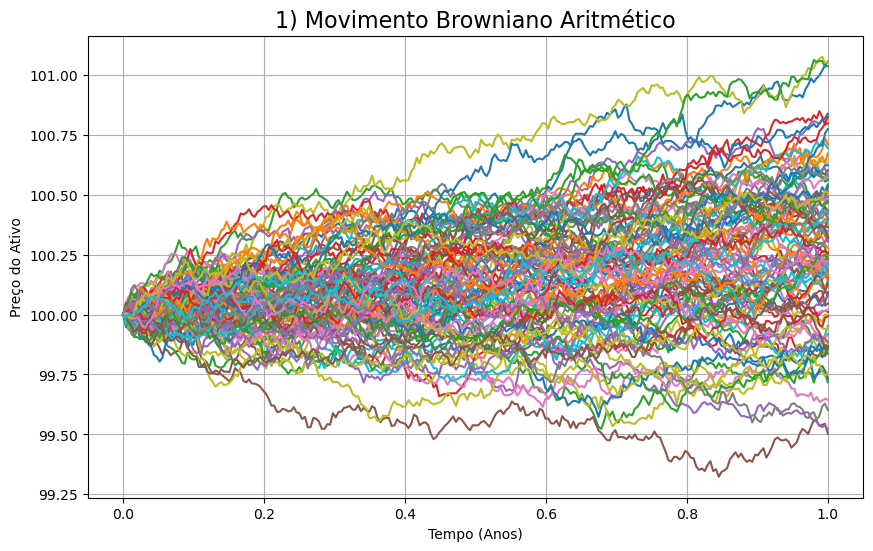

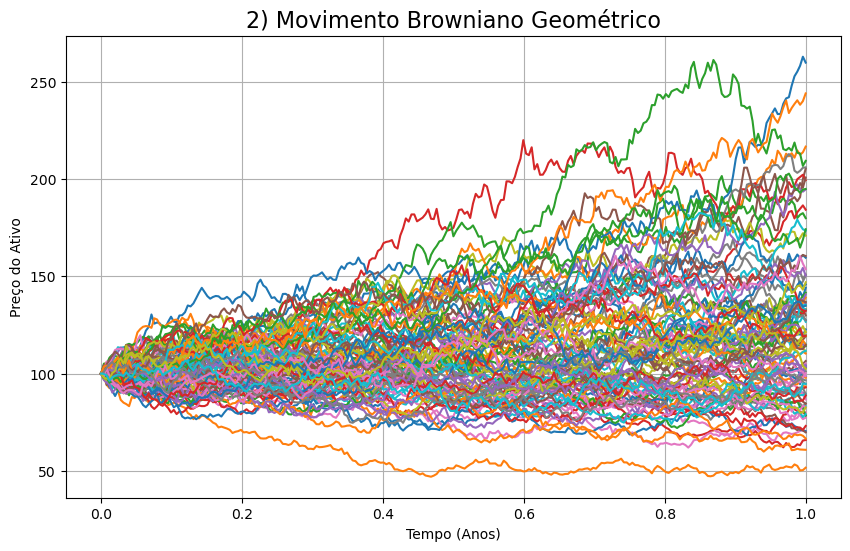

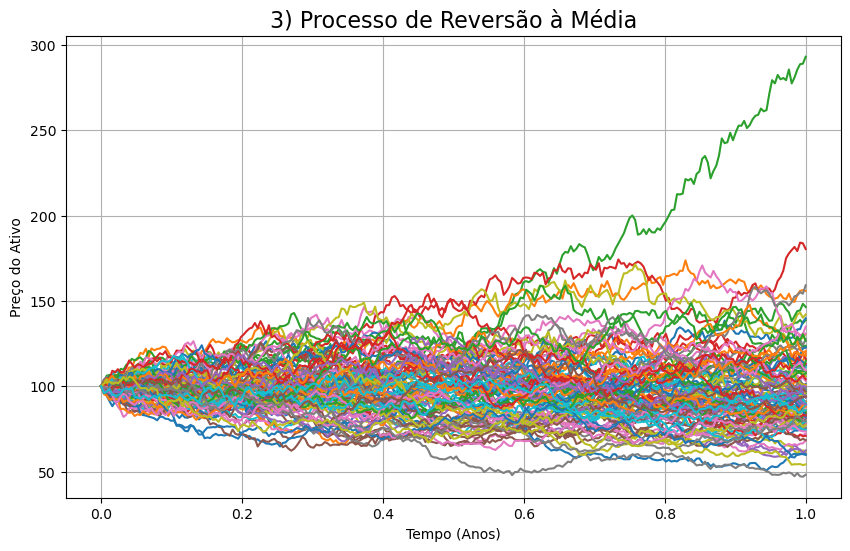

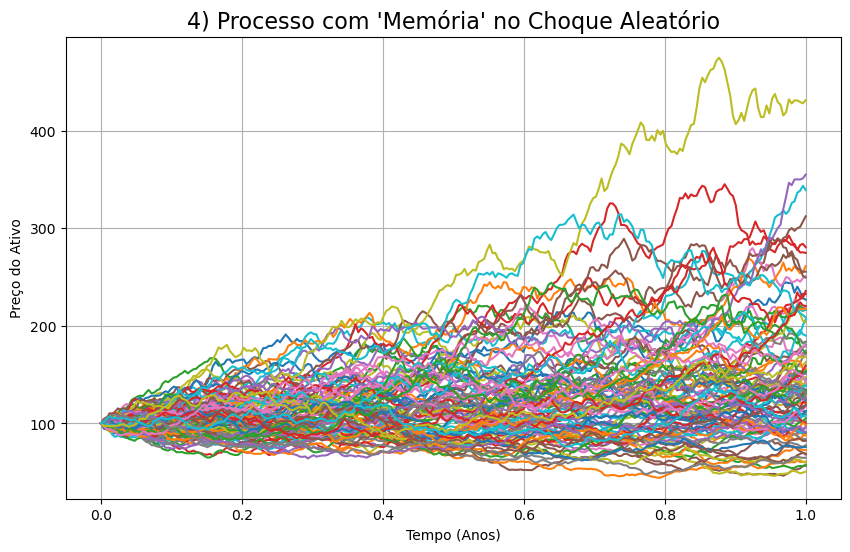

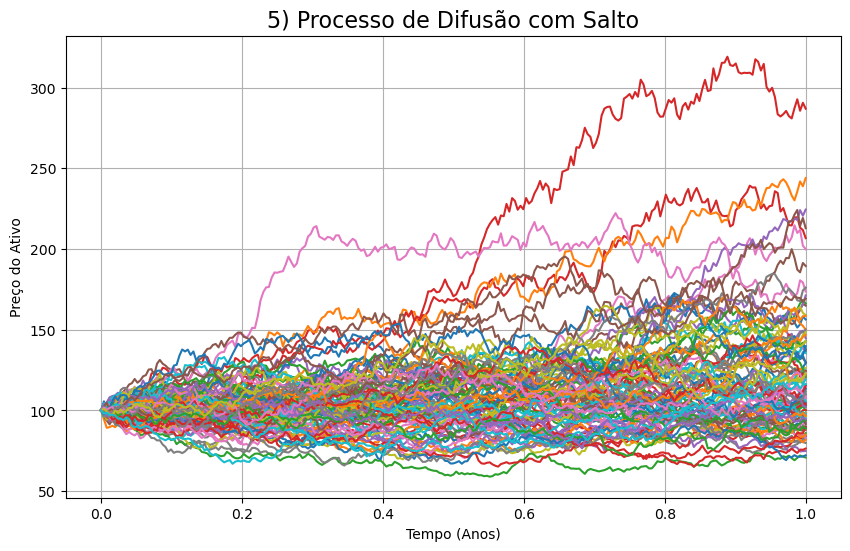

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# SEÇÃO DE PARAMETRIZAÇÃO
# ==============================================================================
# Parâmetros gerais da simulação
P0 = 100.0       # Preço inicial do ativo
T = 1.0          # Tempo total da simulação em anos
N_STEPS = 252    # Número de passos (dias úteis em um ano)
N_SIMS = 100     # Número de simulações (trajetórias de preço)
dt = T / N_STEPS # Tamanho do passo de tempo

# Parâmetros específicos dos modelos
mu = 0.20        # Drift (retorno esperado anual)
sigma = 0.30     # Volatilidade anual

# Parâmetros para modelos específicos
P_bar = 110.0    # Nível de reversão à média (para o Processo 3)
p_jump = 0.02    # Probabilidade de um salto em um passo de tempo (para o Processo 5)
sigma_j = 0.50   # Volatilidade do tamanho do salto (para o Processo 5)

# ==============================================================================
# FUNÇÕES DE SIMULAÇÃO
# ==============================================================================

def simulate_process_1(p0, n_steps, n_sims, dt, mu, sigma):
    """ 1) ΔP(t+1) = μΔt + σN(0, Δt) - Movimento Browniano Aritmético """
    prices = np.zeros((n_steps + 1, n_sims))
    prices[0, :] = p0
    
    for i in range(1, n_steps + 1):
        # Gera o choque aleatório para todas as simulações de uma vez
        random_shock = np.random.normal(0, np.sqrt(dt), n_sims)
        # Calcula a mudança no preço (ΔP)
        delta_p = mu * dt + sigma * random_shock
        # Atualiza o preço
        prices[i, :] = prices[i-1, :] + delta_p
        
    return prices

def simulate_process_2(p0, n_steps, n_sims, dt, mu, sigma):
    """ 2) ΔP(t+1) = μP(t)Δt + σP(t)N(0, Δt) - Movimento Browniano Geométrico """
    prices = np.zeros((n_steps + 1, n_sims))
    prices[0, :] = p0
    
    for i in range(1, n_steps + 1):
        random_shock = np.random.normal(0, np.sqrt(dt), n_sims)
        # ΔP é proporcional ao preço atual P(t)
        delta_p = mu * prices[i-1, :] * dt + sigma * prices[i-1, :] * random_shock
        prices[i, :] = prices[i-1, :] + delta_p
        
    return prices

def simulate_process_3(p0, n_steps, n_sims, dt, mu, p_bar, sigma):
    """ 3) ΔP(t+1) = μ(P_bar - P(t))Δt + σP(t)N(0, Δt) - Reversão à Média """
    prices = np.zeros((n_steps + 1, n_sims))
    prices[0, :] = p0
    
    for i in range(1, n_steps + 1):
        random_shock = np.random.normal(0, np.sqrt(dt), n_sims)
        # O drift agora puxa o preço em direção a P_bar
        drift = mu * (p_bar - prices[i-1, :]) * dt
        volatility_term = sigma * prices[i-1, :] * random_shock
        delta_p = drift + volatility_term
        prices[i, :] = prices[i-1, :] + delta_p
        
    return prices

def simulate_process_4(p0, n_steps, n_sims, dt, mu, sigma):
    """ 4) ΔP(t+1) = μP(t)Δt + σP(t)N(ΔP(t)/P(t-1), Δt) - Modelo com 'Memória' """
    prices = np.zeros((n_steps + 1, n_sims))
    prices[0, :] = p0
    # Para o primeiro passo, não há P(t-1), então o retorno anterior é 0
    prices[1, :] = p0 + (mu * p0 * dt + sigma * p0 * np.random.normal(0, np.sqrt(dt), n_sims))

    for i in range(2, n_steps + 1):
        # Calcula o retorno do período anterior
        prev_return = (prices[i-1, :] - prices[i-2, :]) / prices[i-2, :]
        # A média do choque aleatório é o retorno anterior
        random_shock = np.random.normal(prev_return, np.sqrt(dt), n_sims)
        delta_p = mu * prices[i-1, :] * dt + sigma * prices[i-1, :] * random_shock
        prices[i, :] = prices[i-1, :] + delta_p
        
    return prices

def simulate_process_5(p0, n_steps, n_sims, dt, mu, sigma, p_jump, sigma_j):
    """ 5) ΔP(t+1) = μP(t)Δt + σP(t)N1(0,Δt) + σ_j*Bern(p)*P(t)*N2(0,Δt) - Difusão com Salto """
    prices = np.zeros((n_steps + 1, n_sims))
    prices[0, :] = p0
    
    for i in range(1, n_steps + 1):
        # Choque da difusão contínua (N1)
        diffusion_shock = np.random.normal(0, np.sqrt(dt), n_sims)
        # Determina se um salto ocorre (Bernoulli)
        jump_trigger = np.random.binomial(1, p_jump, n_sims)
        # Choque do tamanho do salto (N2), independente de N1
        jump_size_shock = np.random.normal(0, np.sqrt(dt), n_sims)
        
        # Termo de difusão
        diffusion_term = sigma * prices[i-1, :] * diffusion_shock
        # Termo de salto
        jump_term = sigma_j * jump_trigger * prices[i-1, :] * jump_size_shock
        
        # ΔP com drift, difusão e salto
        delta_p = mu * prices[i-1, :] * dt + diffusion_term + jump_term
        prices[i, :] = prices[i-1, :] + delta_p
        
    return prices

def plot_simulation(prices, title):
    """ Função para plotar os resultados da simulação. """
    time_vector = np.linspace(0, T, N_STEPS + 1)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(time_vector, prices)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Tempo (Anos)")
    ax.set_ylabel("Preço do Ativo")
    ax.grid(True)
    plt.show()

# ==============================================================================
# EXECUÇÃO PRINCIPAL
# ==============================================================================
if __name__ == "__main__":
    # Simulação e plotagem para cada processo
    
    prices_1 = simulate_process_1(P0, N_STEPS, N_SIMS, dt, mu, sigma)
    plot_simulation(prices_1, "1) Movimento Browniano Aritmético")
    
    prices_2 = simulate_process_2(P0, N_STEPS, N_SIMS, dt, mu, sigma)
    plot_simulation(prices_2, "2) Movimento Browniano Geométrico")

    prices_3 = simulate_process_3(P0, N_STEPS, N_SIMS, dt, mu, P_bar, sigma)
    plot_simulation(prices_3, "3) Processo de Reversão à Média")

    prices_4 = simulate_process_4(P0, N_STEPS, N_SIMS, dt, mu, sigma)
    plot_simulation(prices_4, "4) Processo com 'Memória' no Choque Aleatório")

    prices_5 = simulate_process_5(P0, N_STEPS, N_SIMS, dt, mu, sigma, p_jump, sigma_j)
    plot_simulation(prices_5, "5) Processo de Difusão com Salto")